In [1]:
# ============================================================
# CELL 1: IMPORTS AND SETUP
# ============================================================
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Start timing
START_TIME = time.time()

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 2.1.0+cu121
CUDA available: True
GPU: NVIDIA A100 80GB PCIe
Using device: cuda


In [2]:
# ============================================================
# CELL 2: CONFIGURATION
# ============================================================

# Dataset paths
TRAIN_BASE = "/data1/Siri/MeasuringCup/BMC_OR/OR_training"
TEST_BASE = "/data1/Siri/MeasuringCup/BMC_OR/OR_testing"
MODEL_SAVE_PATH = "/data1/Siri/MeasuringCup/BMC_OR/OR_code/resnet50_bmcor_best.pth"

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-3
DROPOUT_1 = 0.4
DROPOUT_2 = 0.2
HIDDEN_UNITS = 256
FREEZE_RATIO = 0.4  # Freeze bottom 40%, train top 60%

print("Configuration:")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Dropout: {DROPOUT_1}/{DROPOUT_2}")
print(f"  Hidden Units: {HIDDEN_UNITS}")
print(f"  Freeze Ratio: {FREEZE_RATIO} (train top {100-int(FREEZE_RATIO*100)}%)")

Configuration:
  Image Size: 224x224
  Batch Size: 16
  Epochs: 50
  Learning Rate: 0.001
  Dropout: 0.4/0.2
  Hidden Units: 256
  Freeze Ratio: 0.4 (train top 60%)


In [3]:
# ============================================================
# CELL 3: DATASET CLASS
# ============================================================

class MeasuringCupDataset(Dataset):
    """Dataset for BMC_OR measuring cup images."""

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

print("Dataset class defined.")

Dataset class defined.


In [4]:
# ============================================================
# CELL 4: DATA COLLECTION FUNCTION
# ============================================================

def collect_images_or(base_folder):
    """
    Collect images from BMC_OR flat folder structure.
    
    BMC_OR structure:
    - No BV/FV subfolders (unlike BMC_NewResized)
    - Images are directly in volume folders
    - Image names have BV/FV prefix (e.g., BV100_001_030.jpg)
    """
    X_paths = []
    Y = []
    
    for volume_folder in sorted(os.listdir(base_folder)):
        if not volume_folder.isdigit():
            continue
        
        vol_path = os.path.join(base_folder, volume_folder)
        if not os.path.isdir(vol_path):
            continue
        
        for img_file in sorted(os.listdir(vol_path)):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                X_paths.append(os.path.join(vol_path, img_file))
                Y.append(int(volume_folder))
    
    return X_paths, np.array(Y, dtype=np.float32)

print("Data collection function defined.")

Data collection function defined.


In [5]:
# ============================================================
# CELL 5: LOAD DATA
# ============================================================
print("="*60)
print("LOADING DATA")
print("="*60)

train_paths, Y_train = collect_images_or(TRAIN_BASE)
test_paths, Y_test = collect_images_or(TEST_BASE)

print(f"\nTraining images: {len(train_paths)}")
print(f"Testing images: {len(test_paths)}")
print(f"Volume range: {Y_train.min():.0f} - {Y_train.max():.0f} mL")
print(f"Mean volume: {Y_train.mean():.1f} mL")

# Transforms with ImageNet normalization (CRITICAL for pretrained models)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MeasuringCupDataset(train_paths, Y_train, train_transform)
test_dataset = MeasuringCupDataset(test_paths, Y_test, test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"\nDatasets created successfully.")

LOADING DATA

Training images: 794
Testing images: 107
Volume range: 100 - 610 mL
Mean volume: 344.4 mL

Datasets created successfully.


In [6]:
# ============================================================
# CELL 6: BUILD MODEL - ResNet50
# ============================================================
print("="*60)
print("BUILDING MODEL")
print("="*60)

class ResNet50Regressor(nn.Module):
    """ResNet50 with custom regression head."""

    def __init__(self, dropout_1=0.4, dropout_2=0.2, hidden_units=256, freeze_ratio=0.4):
        super().__init__()

        # Load pretrained ResNet50
        self.base = models.resnet50(weights='IMAGENET1K_V1')

        # Freeze layers based on freeze_ratio
        all_params = list(self.base.parameters())
        freeze_point = int(len(all_params) * freeze_ratio)
        for i, param in enumerate(all_params):
            param.requires_grad = (i >= freeze_point)

        # Get feature dimension from fc layer
        in_features = self.base.fc.in_features

        # Replace fc with custom regression head
        self.base.fc = nn.Sequential(
            nn.Dropout(dropout_1),
            nn.Linear(in_features, hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_2),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.base(x).squeeze(-1)

model = ResNet50Regressor(
    dropout_1=DROPOUT_1,
    dropout_2=DROPOUT_2,
    hidden_units=HIDDEN_UNITS,
    freeze_ratio=FREEZE_RATIO
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

BUILDING MODEL
Total parameters: 24,032,833
Trainable parameters: 22,802,433


In [7]:
# ============================================================
# CELL 7: TRAINING SETUP
# ============================================================

criterion = nn.L1Loss()  # MAE loss
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

print("Training setup:")
print("  - Loss: L1Loss (MAE)")
print("  - Optimizer: Adam")
print("  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")

Training setup:
  - Loss: L1Loss (MAE)
  - Optimizer: Adam
  - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


In [8]:
# ============================================================
# CELL 8: TRAIN MODEL
# ============================================================
print("="*60)
print("TRAINING MODEL")
print("="*60)

training_start = time.time()

best_val_mae = float('inf')
best_model_state = None
patience_counter = 0
history = {'train_mae': [], 'val_mae': [], 'lr': []}

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * len(labels)

    train_mae = train_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item() * len(labels)

    val_mae = val_loss / len(test_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['lr'].append(current_lr)

    scheduler.step(val_mae)

    # Save best model
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"Epoch {epoch+1:3d}: Train MAE={train_mae:.2f}, Val MAE={val_mae:.2f}, LR={current_lr:.2e} *BEST*")
        torch.save(best_model_state, MODEL_SAVE_PATH)
    else:
        patience_counter += 1
        print(f"Epoch {epoch+1:3d}: Train MAE={train_mae:.2f}, Val MAE={val_mae:.2f}, LR={current_lr:.2e}")

    # Early stopping
    if patience_counter >= 10:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

training_time = time.time() - training_start
print(f"\nTraining completed in {training_time/60:.2f} minutes")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Best model loaded (Val MAE: {best_val_mae:.4f})")

TRAINING MODEL
Epoch   1: Train MAE=146.67, Val MAE=330.41, LR=1.00e-03 *BEST*
Epoch   2: Train MAE=37.03, Val MAE=53.52, LR=1.00e-03 *BEST*
Epoch   3: Train MAE=32.81, Val MAE=20.66, LR=1.00e-03 *BEST*
Epoch   4: Train MAE=26.26, Val MAE=24.06, LR=1.00e-03
Epoch   5: Train MAE=33.20, Val MAE=10.62, LR=1.00e-03 *BEST*
Epoch   6: Train MAE=25.17, Val MAE=51.93, LR=1.00e-03
Epoch   7: Train MAE=22.17, Val MAE=17.96, LR=1.00e-03
Epoch   8: Train MAE=21.13, Val MAE=13.89, LR=1.00e-03
Epoch   9: Train MAE=21.62, Val MAE=10.05, LR=1.00e-03 *BEST*
Epoch  10: Train MAE=19.86, Val MAE=84.28, LR=1.00e-03
Epoch  11: Train MAE=25.21, Val MAE=8.65, LR=1.00e-03 *BEST*
Epoch  12: Train MAE=18.99, Val MAE=16.92, LR=1.00e-03
Epoch  13: Train MAE=17.85, Val MAE=13.31, LR=1.00e-03
Epoch  14: Train MAE=22.24, Val MAE=6.86, LR=1.00e-03 *BEST*
Epoch  15: Train MAE=20.67, Val MAE=25.07, LR=1.00e-03
Epoch  16: Train MAE=17.34, Val MAE=6.13, LR=1.00e-03 *BEST*
Epoch  17: Train MAE=16.43, Val MAE=5.96, LR=1.00e

In [9]:
# ============================================================
# CELL 9: EVALUATE MODEL
# ============================================================
print("="*60)
print("EVALUATING MODEL")
print("="*60)

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.numpy())

predictions = np.array(predictions)
actuals = np.array(actuals)

mae = np.mean(np.abs(actuals - predictions))
accuracies = 100 * (1 - np.abs(actuals - predictions) / actuals)
avg_accuracy = np.mean(accuracies)

samples_above_95 = np.sum(accuracies > 95)
samples_above_90 = np.sum(accuracies > 90)
samples_above_85 = np.sum(accuracies > 85)

print(f"\nTest Results:")
print(f"  MAE: {mae:.4f} mL")
print(f"  Average Accuracy: {avg_accuracy:.2f}%")
print(f"  Samples >95% accuracy: {samples_above_95}/{len(accuracies)} ({100*samples_above_95/len(accuracies):.1f}%)")
print(f"  Samples >90% accuracy: {samples_above_90}/{len(accuracies)} ({100*samples_above_90/len(accuracies):.1f}%)")
print(f"  Samples >85% accuracy: {samples_above_85}/{len(accuracies)} ({100*samples_above_85/len(accuracies):.1f}%)")

EVALUATING MODEL

Test Results:
  MAE: 9.6422 mL
  Average Accuracy: 96.74%
  Samples >95% accuracy: 91/107 (85.0%)
  Samples >90% accuracy: 106/107 (99.1%)
  Samples >85% accuracy: 107/107 (100.0%)


In [10]:
# ============================================================
# CELL 10: FINAL RESULTS SUMMARY
# ============================================================

total_time = time.time() - START_TIME
minutes = int(total_time // 60)
seconds = int(total_time % 60)

print("="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\n{'='*40}")
print(f"  Final Test MAE: {mae:.4f} mL")
print(f"  Average Accuracy: {avg_accuracy:.2f}%")
print(f"  Total Execution Time: {minutes:02d}:{seconds:02d} (mm:ss)")
print(f"{'='*40}")

if mae < 10:
    print(f"\n*** SUCCESS: MAE < 10 goal ACHIEVED! ***")
else:
    print(f"\nNote: MAE is {mae:.2f} mL, goal was < 10 mL")

FINAL RESULTS SUMMARY

  Final Test MAE: 9.6422 mL
  Average Accuracy: 96.74%
  Total Execution Time: 16:13 (mm:ss)

*** SUCCESS: MAE < 10 goal ACHIEVED! ***


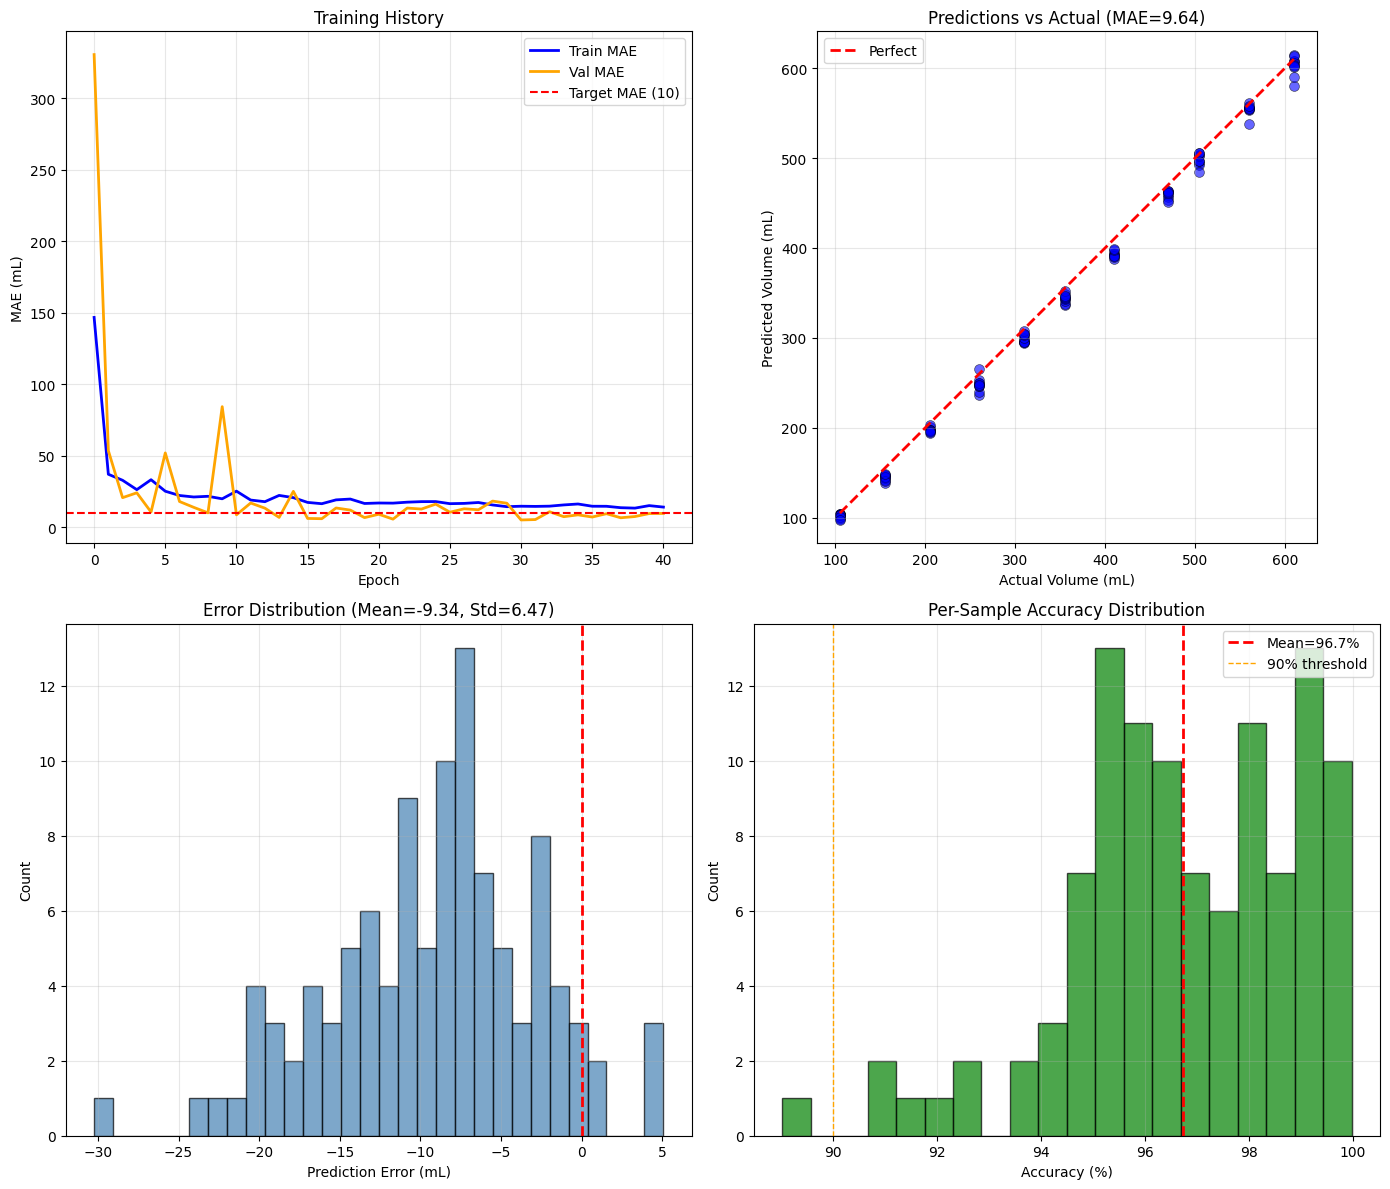

Saved: resnet50_results.png


In [11]:
# ============================================================
# CELL 11: VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Training History
ax1 = axes[0, 0]
ax1.plot(history['train_mae'], 'b-', label='Train MAE', linewidth=2)
ax1.plot(history['val_mae'], 'orange', label='Val MAE', linewidth=2)
ax1.axhline(y=10, color='r', linestyle='--', label='Target MAE (10)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MAE (mL)')
ax1.set_title('Training History')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Predictions vs Actual
ax2 = axes[0, 1]
ax2.scatter(actuals, predictions, alpha=0.6, s=50, c='blue', edgecolors='black', linewidth=0.5)
ax2.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2, label='Perfect')
ax2.set_xlabel('Actual Volume (mL)')
ax2.set_ylabel('Predicted Volume (mL)')
ax2.set_title(f'Predictions vs Actual (MAE={mae:.2f})')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal', adjustable='box')

# 3. Prediction Errors
ax3 = axes[1, 0]
errors = predictions - actuals
ax3.hist(errors, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Prediction Error (mL)')
ax3.set_ylabel('Count')
ax3.set_title(f'Error Distribution (Mean={np.mean(errors):.2f}, Std={np.std(errors):.2f})')
ax3.grid(True, alpha=0.3)

# 4. Accuracy Distribution
ax4 = axes[1, 1]
ax4.hist(accuracies, bins=20, color='green', edgecolor='black', alpha=0.7)
ax4.axvline(x=avg_accuracy, color='r', linestyle='--', linewidth=2, label=f'Mean={avg_accuracy:.1f}%')
ax4.axvline(x=90, color='orange', linestyle='--', linewidth=1, label='90% threshold')
ax4.set_xlabel('Accuracy (%)')
ax4.set_ylabel('Count')
ax4.set_title('Per-Sample Accuracy Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/data1/Siri/MeasuringCup/BMC_OR/OR_code/resnet50_results.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: resnet50_results.png")

In [12]:
# ============================================================
# CELL 12: SAMPLE PREDICTIONS
# ============================================================

sorted_idx = np.argsort(accuracies)

print("\n" + "="*60)
print("TOP 15 BEST PREDICTIONS")
print("="*60)
best_15 = sorted_idx[-15:][::-1]
for i, idx in enumerate(best_15):
    print(f"{i+1:2d}. Actual: {actuals[idx]:>6.0f} mL, Predicted: {predictions[idx]:>7.2f} mL, Accuracy: {accuracies[idx]:>6.2f}%")

print("\n" + "="*60)
print("TOP 15 WORST PREDICTIONS")
print("="*60)
worst_15 = sorted_idx[:15]
for i, idx in enumerate(worst_15):
    print(f"{i+1:2d}. Actual: {actuals[idx]:>6.0f} mL, Predicted: {predictions[idx]:>7.2f} mL, Accuracy: {accuracies[idx]:>6.2f}%")


TOP 15 BEST PREDICTIONS
 1. Actual:    505 mL, Predicted:  505.13 mL, Accuracy:  99.97%
 2. Actual:    505 mL, Predicted:  505.64 mL, Accuracy:  99.87%
 3. Actual:    505 mL, Predicted:  503.86 mL, Accuracy:  99.77%
 4. Actual:    560 mL, Predicted:  561.40 mL, Accuracy:  99.75%
 5. Actual:    610 mL, Predicted:  607.54 mL, Accuracy:  99.60%
 6. Actual:    610 mL, Predicted:  607.40 mL, Accuracy:  99.57%
 7. Actual:    560 mL, Predicted:  557.60 mL, Accuracy:  99.57%
 8. Actual:    505 mL, Predicted:  502.72 mL, Accuracy:  99.55%
 9. Actual:    105 mL, Predicted:  104.46 mL, Accuracy:  99.48%
10. Actual:    560 mL, Predicted:  556.89 mL, Accuracy:  99.44%
11. Actual:    105 mL, Predicted:  104.36 mL, Accuracy:  99.39%
12. Actual:    610 mL, Predicted:  613.94 mL, Accuracy:  99.35%
13. Actual:    610 mL, Predicted:  605.39 mL, Accuracy:  99.24%
14. Actual:    205 mL, Predicted:  203.39 mL, Accuracy:  99.21%
15. Actual:    560 mL, Predicted:  555.50 mL, Accuracy:  99.20%

TOP 15 WORST P

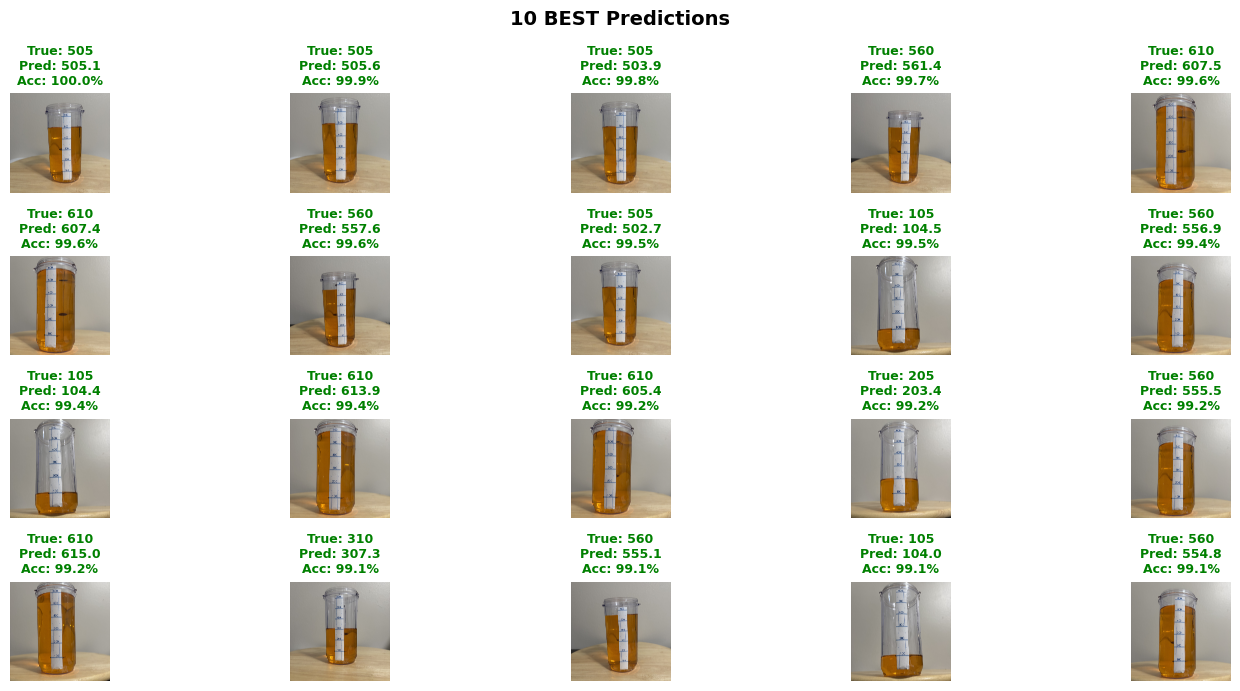

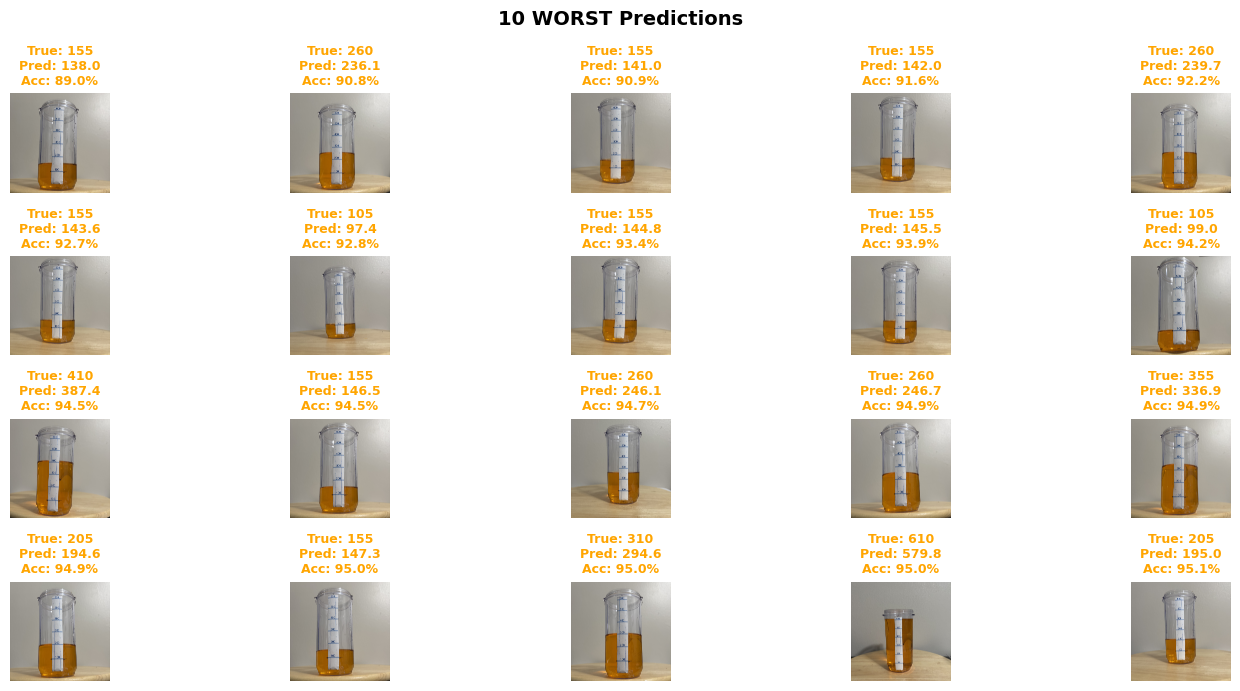

Saved: resnet50_best10.png, resnet50_worst10.png


In [15]:
# ============================================================
# CELL 13: VISUALIZE BEST AND WORST PREDICTIONS
# ============================================================

# Show 10 best predictions
fig, axes = plt.subplots(4, 5, figsize=(15, 7))
fig.suptitle('10 BEST Predictions', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    idx = sorted_idx[-(i+1)]
    img = Image.open(test_paths[idx])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"True: {actuals[idx]:.0f}\nPred: {predictions[idx]:.1f}\nAcc: {accuracies[idx]:.1f}%",
                fontsize=9, color='green', fontweight='bold')

plt.tight_layout()
plt.savefig('/data1/Siri/MeasuringCup/BMC_OR/OR_code/resnet50_best10.png', dpi=300, bbox_inches='tight')
plt.show()

# Show 10 worst predictions
fig, axes = plt.subplots(4, 5, figsize=(15, 7))
fig.suptitle('10 WORST Predictions', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    idx = sorted_idx[i]
    img = Image.open(test_paths[idx])
    ax.imshow(img)
    ax.axis('off')
    color = 'orange' if accuracies[idx] > 80 else 'red'
    ax.set_title(f"True: {actuals[idx]:.0f}\nPred: {predictions[idx]:.1f}\nAcc: {accuracies[idx]:.1f}%",
                fontsize=9, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig('/data1/Siri/MeasuringCup/BMC_OR/OR_code/resnet50_worst10.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: resnet50_best10.png, resnet50_worst10.png")

In [14]:
# ============================================================
# CELL 14: FINAL SUMMARY
# ============================================================

print("\n" + "#"*60)
print("#" + " "*58 + "#")
print("#" + "       ResNet50 BMC_OR VOLUME PREDICTION".center(58) + "#")
print("#" + " "*58 + "#")
print("#"*60)
print(f"#" + f"  Final Test MAE: {mae:.4f} mL".ljust(58) + "#")
print(f"#" + f"  Average Accuracy: {avg_accuracy:.2f}%".ljust(58) + "#")
print(f"#" + f"  Total Execution Time: {minutes:02d}:{seconds:02d}".ljust(58) + "#")
print("#" + "-"*58 + "#")
print(f"#" + f"  Training samples: {len(train_dataset)}".ljust(58) + "#")
print(f"#" + f"  Test samples: {len(test_dataset)}".ljust(58) + "#")
print(f"#" + f"  Model: ResNet50 (top {100-int(FREEZE_RATIO*100)}% trainable)".ljust(58) + "#")
print(f"#" + f"  Epochs trained: {len(history['train_mae'])}".ljust(58) + "#")
print("#"*60)

if mae < 10:
    print("\n" + "*"*60)
    print("*" + "  GOAL ACHIEVED: MAE < 10 mL  ".center(58, '*') + "*")
    print("*"*60)


############################################################
#                                                          #
#                ResNet50 BMC_OR VOLUME PREDICTION         #
#                                                          #
############################################################
#  Final Test MAE: 9.6422 mL                               #
#  Average Accuracy: 96.74%                                #
#  Total Execution Time: 16:13                             #
#----------------------------------------------------------#
#  Training samples: 794                                   #
#  Test samples: 107                                       #
#  Model: ResNet50 (top 60% trainable)                     #
#  Epochs trained: 41                                      #
############################################################

************************************************************
***************  GOAL ACHIEVED: MAE < 10 mL  ***************
**********************

# ES (1+1) with 1/5 Success Rule

Now we apply **Evolution Strategy (1+1)** with the **1/5 success rule** to optimize the hyperparameters.

**1/5 Success Rule:**
- If success rate > 1/5: increase mutation step (exploration)
- If success rate < 1/5: decrease mutation step (exploitation)
- Adapts automatically to find optimal step size

In [16]:
# ============================================================
# CELL 16: ES (1+1) CONFIGURATION
# ============================================================
print("="*60)
print("ES (1+1) WITH 1/5 SUCCESS RULE - CONFIGURATION")
print("="*60)

ES_START_TIME = time.time()

# Baseline parameters (from the trained model above)
BASELINE_PARAMS = {
    'learning_rate': 1e-3,
    'dropout_1': 0.4,
    'dropout_2': 0.2,
    'hidden_units': 256,
    'freeze_ratio': 0.4
}

# Parameter bounds
PARAM_BOUNDS = {
    'learning_rate': (1e-5, 1e-2),   # log scale
    'dropout_1': (0.1, 0.6),          # linear scale
    'dropout_2': (0.05, 0.4),         # linear scale
    'hidden_units': (64, 512),        # discrete (will be rounded)
    'freeze_ratio': (0.2, 0.8)        # linear scale
}

# ES (1+1) hyperparameters
ES_CONFIG = {
    'initial_sigma': 0.2,        # Initial mutation strength (relative)
    'c': 0.82,                   # Adaptation factor (approx e^(-1/n))
    'k': 5,                      # Check interval for 1/5 rule
    'max_generations': 20,       # Maximum generations
    'epochs_per_eval': 30,       # Training epochs per evaluation (faster)
    'target_success_rate': 0.2   # 1/5 success rule target
}

print(f"\nBaseline Parameters:")
for name, value in BASELINE_PARAMS.items():
    print(f"  {name}: {value}")

print(f"\nES Configuration:")
for name, value in ES_CONFIG.items():
    print(f"  {name}: {value}")

print(f"\nParameter Bounds:")
for name, (low, high) in PARAM_BOUNDS.items():
    print(f"  {name}: [{low}, {high}]")

ES (1+1) WITH 1/5 SUCCESS RULE - CONFIGURATION

Baseline Parameters:
  learning_rate: 0.001
  dropout_1: 0.4
  dropout_2: 0.2
  hidden_units: 256
  freeze_ratio: 0.4

ES Configuration:
  initial_sigma: 0.2
  c: 0.82
  k: 5
  max_generations: 20
  epochs_per_eval: 30
  target_success_rate: 0.2

Parameter Bounds:
  learning_rate: [1e-05, 0.01]
  dropout_1: [0.1, 0.6]
  dropout_2: [0.05, 0.4]
  hidden_units: [64, 512]
  freeze_ratio: [0.2, 0.8]


In [17]:
# ============================================================
# CELL 17: ES (1+1) HELPER FUNCTIONS
# ============================================================

def mutate_params(parent, sigma, bounds):
    """
    Mutate parameters using Gaussian noise.
    Uses log scale for learning_rate, linear for others.
    """
    child = {}
    for name, value in parent.items():
        low, high = bounds[name]
        
        if name == 'learning_rate':
            # Log scale mutation for learning rate
            log_value = np.log10(value)
            log_low, log_high = np.log10(low), np.log10(high)
            log_range = log_high - log_low
            mutation = np.random.randn() * sigma * log_range
            new_log_value = np.clip(log_value + mutation, log_low, log_high)
            child[name] = 10 ** new_log_value
        elif name == 'hidden_units':
            # Discrete mutation for hidden_units
            range_size = high - low
            mutation = np.random.randn() * sigma * range_size
            new_value = int(np.clip(value + mutation, low, high))
            # Round to nearest multiple of 32 for efficiency
            child[name] = max(64, min(512, (new_value // 32) * 32))
        else:
            # Linear scale mutation
            range_size = high - low
            mutation = np.random.randn() * sigma * range_size
            child[name] = np.clip(value + mutation, low, high)
    
    return child

def train_and_evaluate(params, train_loader, test_loader, epochs, device):
    """
    Train model with given parameters and return validation MAE.
    """
    # Create model with given parameters
    model = ResNet50Regressor(
        dropout_1=params['dropout_1'],
        dropout_2=params['dropout_2'],
        hidden_units=int(params['hidden_units']),
        freeze_ratio=params['freeze_ratio']
    ).to(device)
    
    criterion = nn.L1Loss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=params['learning_rate']
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=False
    )
    
    best_val_mae = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item() * len(labels)
        
        val_mae = val_loss / len(test_loader.dataset)
        scheduler.step(val_mae)
        
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping within ES evaluation
        if patience_counter >= 5:
            break
    
    return best_val_mae, model

def adapt_sigma(sigma, successes, k, c, target_rate=0.2):
    """
    Adapt sigma using 1/5 success rule.
    """
    success_rate = sum(successes[-k:]) / k if len(successes) >= k else sum(successes) / len(successes)
    
    if success_rate > target_rate:
        # Too many successes -> increase exploration
        new_sigma = sigma / c  # Increase sigma
    elif success_rate < target_rate:
        # Too few successes -> decrease exploration
        new_sigma = sigma * c  # Decrease sigma
    else:
        new_sigma = sigma
    
    # Clamp sigma to reasonable range
    new_sigma = np.clip(new_sigma, 0.01, 0.5)
    
    return new_sigma, success_rate

print("ES helper functions defined:")
print("  - mutate_params(): Apply Gaussian mutation with bounds")
print("  - train_and_evaluate(): Train model and return MAE")
print("  - adapt_sigma(): Implement 1/5 success rule")

ES helper functions defined:
  - mutate_params(): Apply Gaussian mutation with bounds
  - train_and_evaluate(): Train model and return MAE
  - adapt_sigma(): Implement 1/5 success rule


In [18]:
# ============================================================
# CELL 18: ES (1+1) MAIN OPTIMIZATION LOOP
# ============================================================
print("="*60)
print("ES (1+1) OPTIMIZATION - TARGET: MAE < 5")
print("="*60)

# Initialize parent with baseline parameters
parent = BASELINE_PARAMS.copy()
sigma = ES_CONFIG['initial_sigma']

# Evaluate baseline
print("\nEvaluating baseline parameters...")
baseline_mae, _ = train_and_evaluate(
    parent, train_loader, test_loader, 
    ES_CONFIG['epochs_per_eval'], device
)
parent_mae = baseline_mae
print(f"Baseline MAE: {baseline_mae:.4f} mL")

# ES history tracking
es_history = {
    'generation': [0],
    'mae': [baseline_mae],
    'sigma': [sigma],
    'params': [parent.copy()],
    'success': [False]
}

successes = []
best_params = parent.copy()
best_mae = parent_mae
best_model = None

print(f"\nStarting ES (1+1) optimization...")
print(f"Max generations: {ES_CONFIG['max_generations']}")
print(f"Target MAE: < 5.0 mL")
print("-"*60)

for gen in range(1, ES_CONFIG['max_generations'] + 1):
    gen_start = time.time()
    
    # Mutate parent to create child
    child = mutate_params(parent, sigma, PARAM_BOUNDS)
    
    # Evaluate child
    child_mae, child_model = train_and_evaluate(
        child, train_loader, test_loader,
        ES_CONFIG['epochs_per_eval'], device
    )
    
    # Selection: (1+1) - child replaces parent if better
    if child_mae < parent_mae:
        parent = child.copy()
        parent_mae = child_mae
        success = True
        marker = "*BETTER*"
        
        # Track global best
        if child_mae < best_mae:
            best_mae = child_mae
            best_params = child.copy()
            best_model = child_model
            marker = "**BEST**"
    else:
        success = False
        marker = ""
    
    successes.append(success)
    
    # Adapt sigma every k generations using 1/5 rule
    if gen % ES_CONFIG['k'] == 0:
        old_sigma = sigma
        sigma, success_rate = adapt_sigma(
            sigma, successes, ES_CONFIG['k'], 
            ES_CONFIG['c'], ES_CONFIG['target_success_rate']
        )
        if sigma != old_sigma:
            print(f"  [1/5 Rule] Success rate: {success_rate:.2f}, Sigma: {old_sigma:.4f} -> {sigma:.4f}")
    
    # Record history
    es_history['generation'].append(gen)
    es_history['mae'].append(child_mae)
    es_history['sigma'].append(sigma)
    es_history['params'].append(child.copy())
    es_history['success'].append(success)
    
    gen_time = time.time() - gen_start
    print(f"Gen {gen:2d}: MAE={child_mae:.4f}, Parent={parent_mae:.4f}, "
          f"Best={best_mae:.4f}, σ={sigma:.4f}, Time={gen_time:.1f}s {marker}")
    
    # Early termination if we achieve target
    if best_mae < 5.0:
        print(f"\n*** TARGET ACHIEVED: MAE < 5.0 at generation {gen} ***")
        break

es_time = time.time() - ES_START_TIME
print("-"*60)
print(f"\nES Optimization completed in {es_time/60:.2f} minutes")
print(f"Best MAE: {best_mae:.4f} mL (Baseline: {baseline_mae:.4f} mL)")
print(f"Improvement: {baseline_mae - best_mae:.4f} mL ({100*(baseline_mae-best_mae)/baseline_mae:.1f}%)")

ES (1+1) OPTIMIZATION - TARGET: MAE < 5

Evaluating baseline parameters...
Baseline MAE: 6.4317 mL

Starting ES (1+1) optimization...
Max generations: 20
Target MAE: < 5.0 mL
------------------------------------------------------------
Gen  1: MAE=7.9967, Parent=6.4317, Best=6.4317, σ=0.2000, Time=218.3s 
Gen  2: MAE=6.9192, Parent=6.4317, Best=6.4317, σ=0.2000, Time=432.0s 
Gen  3: MAE=10.3891, Parent=6.4317, Best=6.4317, σ=0.2000, Time=221.6s 
Gen  4: MAE=13.9320, Parent=6.4317, Best=6.4317, σ=0.2000, Time=204.1s 
  [1/5 Rule] Success rate: 0.00, Sigma: 0.2000 -> 0.1640
Gen  5: MAE=6.4320, Parent=6.4317, Best=6.4317, σ=0.1640, Time=340.7s 
Gen  6: MAE=6.8095, Parent=6.4317, Best=6.4317, σ=0.1640, Time=241.1s 
Gen  7: MAE=6.9343, Parent=6.4317, Best=6.4317, σ=0.1640, Time=392.0s 
Gen  8: MAE=14.9192, Parent=6.4317, Best=6.4317, σ=0.1640, Time=170.5s 
Gen  9: MAE=6.0442, Parent=6.0442, Best=6.0442, σ=0.1640, Time=377.6s **BEST**
Gen 10: MAE=6.5828, Parent=6.0442, Best=6.0442, σ=0.1640,

ES (1+1) OPTIMIZATION RESULTS

BEST PARAMETERS FOUND:
  learning_rate: 1.92e-03 (baseline: 1.00e-03)
  dropout_1: 0.3624 (baseline: 0.4000)
  dropout_2: 0.2547 (baseline: 0.2000)
  hidden_units: 96 (baseline: 256)
  freeze_ratio: 0.2619 (baseline: 0.4000)

PERFORMANCE COMPARISON:
  Baseline MAE: 6.4317 mL
  Best ES MAE:  5.8286 mL
  Improvement:  0.6031 mL (9.4%)


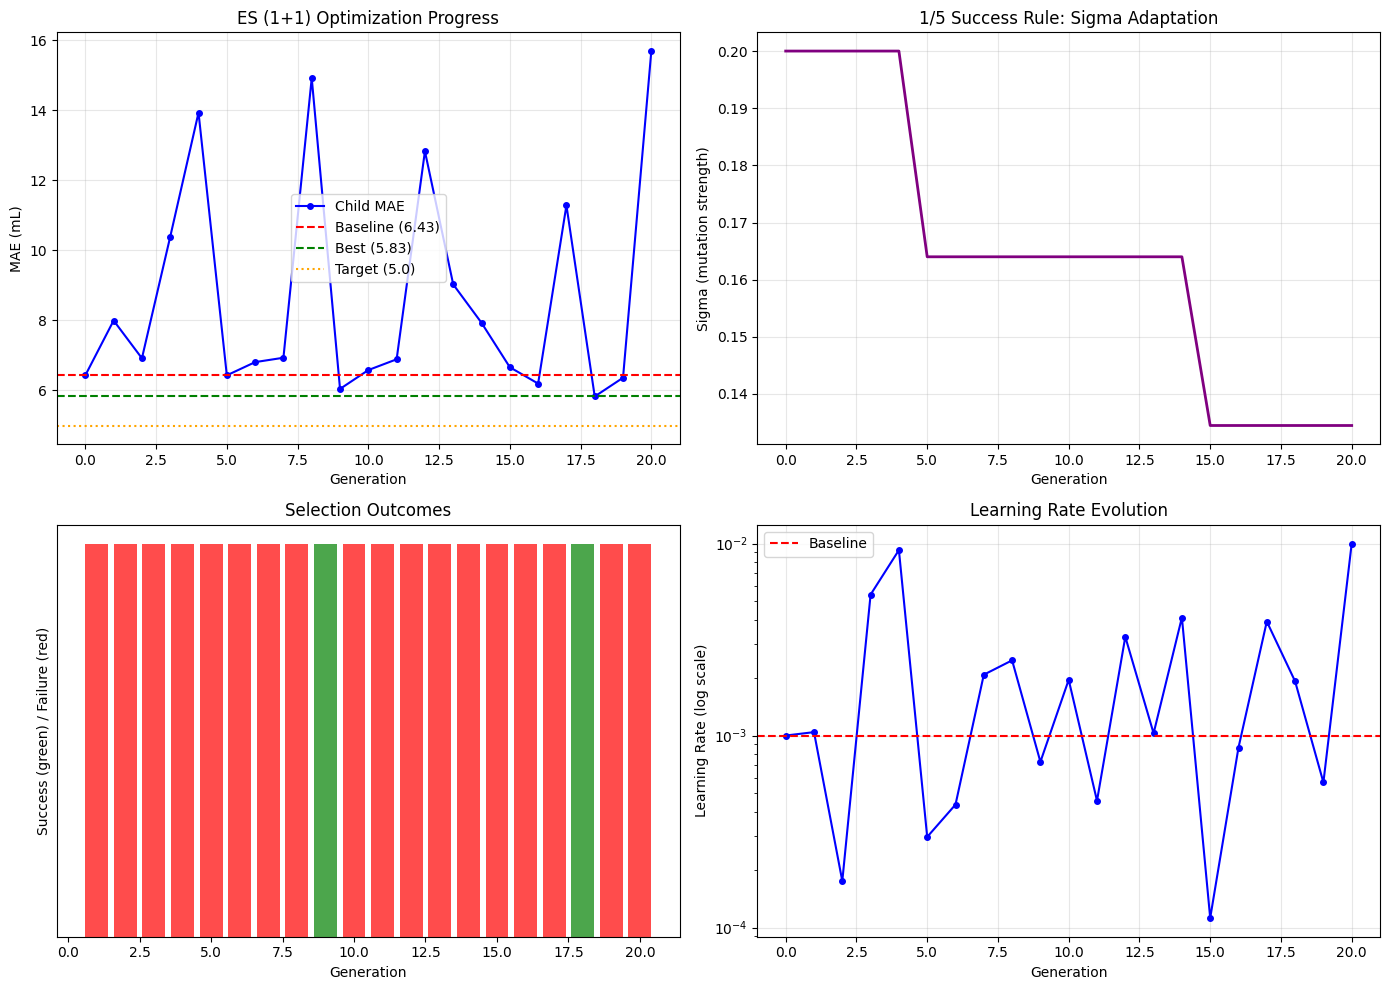


Saved: es_optimization_history.png


In [19]:
# ============================================================
# CELL 19: ES RESULTS AND VISUALIZATION
# ============================================================
print("="*60)
print("ES (1+1) OPTIMIZATION RESULTS")
print("="*60)

print(f"\n{'='*50}")
print("BEST PARAMETERS FOUND:")
print(f"{'='*50}")
for name, value in best_params.items():
    baseline_val = BASELINE_PARAMS[name]
    if name == 'learning_rate':
        print(f"  {name}: {value:.2e} (baseline: {baseline_val:.2e})")
    elif name == 'hidden_units':
        print(f"  {name}: {int(value)} (baseline: {int(baseline_val)})")
    else:
        print(f"  {name}: {value:.4f} (baseline: {baseline_val:.4f})")

print(f"\n{'='*50}")
print("PERFORMANCE COMPARISON:")
print(f"{'='*50}")
print(f"  Baseline MAE: {baseline_mae:.4f} mL")
print(f"  Best ES MAE:  {best_mae:.4f} mL")
print(f"  Improvement:  {baseline_mae - best_mae:.4f} mL ({100*(baseline_mae-best_mae)/baseline_mae:.1f}%)")

# Plot ES optimization history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. MAE over generations
ax1 = axes[0, 0]
generations = es_history['generation']
maes = es_history['mae']
ax1.plot(generations, maes, 'b-o', markersize=4, label='Child MAE')
ax1.axhline(y=baseline_mae, color='r', linestyle='--', label=f'Baseline ({baseline_mae:.2f})')
ax1.axhline(y=best_mae, color='g', linestyle='--', label=f'Best ({best_mae:.2f})')
ax1.axhline(y=5.0, color='orange', linestyle=':', label='Target (5.0)')
ax1.set_xlabel('Generation')
ax1.set_ylabel('MAE (mL)')
ax1.set_title('ES (1+1) Optimization Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Sigma adaptation
ax2 = axes[0, 1]
sigmas = es_history['sigma']
ax2.plot(generations, sigmas, 'purple', linewidth=2)
ax2.set_xlabel('Generation')
ax2.set_ylabel('Sigma (mutation strength)')
ax2.set_title('1/5 Success Rule: Sigma Adaptation')
ax2.grid(True, alpha=0.3)

# 3. Success/Failure visualization
ax3 = axes[1, 0]
success_colors = ['green' if s else 'red' for s in es_history['success'][1:]]
ax3.bar(generations[1:], [1]*len(generations[1:]), color=success_colors, alpha=0.7)
ax3.set_xlabel('Generation')
ax3.set_ylabel('Success (green) / Failure (red)')
ax3.set_title('Selection Outcomes')
ax3.set_yticks([])

# 4. Parameter evolution (learning rate)
ax4 = axes[1, 1]
lrs = [p['learning_rate'] for p in es_history['params']]
ax4.semilogy(generations, lrs, 'b-o', markersize=4)
ax4.axhline(y=BASELINE_PARAMS['learning_rate'], color='r', linestyle='--', label='Baseline')
ax4.set_xlabel('Generation')
ax4.set_ylabel('Learning Rate (log scale)')
ax4.set_title('Learning Rate Evolution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/data1/Siri/MeasuringCup/BMC_OR/OR_code/es_optimization_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nSaved: es_optimization_history.png")

In [20]:
# ============================================================
# CELL 20: FINAL EVALUATION WITH BEST ES PARAMETERS
# ============================================================
print("="*60)
print("FINAL TRAINING WITH BEST ES PARAMETERS")
print("="*60)

print("\nBest parameters from ES:")
for name, value in best_params.items():
    if name == 'learning_rate':
        print(f"  {name}: {value:.2e}")
    elif name == 'hidden_units':
        print(f"  {name}: {int(value)}")
    else:
        print(f"  {name}: {value:.4f}")

print(f"\nTraining for {EPOCHS} epochs (full training)...")

# Train final model with best parameters
final_model = ResNet50Regressor(
    dropout_1=best_params['dropout_1'],
    dropout_2=best_params['dropout_2'],
    hidden_units=int(best_params['hidden_units']),
    freeze_ratio=best_params['freeze_ratio']
).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, final_model.parameters()),
    lr=best_params['learning_rate']
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

best_final_mae = float('inf')
best_final_state = None
patience_counter = 0
final_history = {'train_mae': [], 'val_mae': []}

for epoch in range(EPOCHS):
    # Training
    final_model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(labels)
    
    train_mae = train_loss / len(train_loader.dataset)
    
    # Validation
    final_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = final_model(images)
            val_loss += criterion(outputs, labels).item() * len(labels)
    
    val_mae = val_loss / len(test_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    
    final_history['train_mae'].append(train_mae)
    final_history['val_mae'].append(val_mae)
    
    scheduler.step(val_mae)
    
    if val_mae < best_final_mae:
        best_final_mae = val_mae
        best_final_state = final_model.state_dict().copy()
        patience_counter = 0
        print(f"Epoch {epoch+1:3d}: Train MAE={train_mae:.2f}, Val MAE={val_mae:.2f}, LR={current_lr:.2e} *BEST*")
    else:
        patience_counter += 1
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1:3d}: Train MAE={train_mae:.2f}, Val MAE={val_mae:.2f}, LR={current_lr:.2e}")
    
    if patience_counter >= 10:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
if best_final_state is not None:
    final_model.load_state_dict(best_final_state)

print(f"\nFinal training complete. Best Val MAE: {best_final_mae:.4f} mL")

FINAL TRAINING WITH BEST ES PARAMETERS

Best parameters from ES:
  learning_rate: 1.92e-03
  dropout_1: 0.3624
  dropout_2: 0.2547
  hidden_units: 96
  freeze_ratio: 0.2619

Training for 50 epochs (full training)...
Epoch   1: Train MAE=137.90, Val MAE=166.21, LR=1.92e-03 *BEST*
Epoch   2: Train MAE=47.57, Val MAE=14.73, LR=1.92e-03 *BEST*
Epoch   6: Train MAE=39.31, Val MAE=18.97, LR=1.92e-03
Epoch 00008: reducing learning rate of group 0 to 9.5789e-04.
Epoch   9: Train MAE=35.06, Val MAE=11.65, LR=9.58e-04 *BEST*
Epoch  11: Train MAE=28.62, Val MAE=13.24, LR=9.58e-04
Epoch  12: Train MAE=29.69, Val MAE=9.54, LR=9.58e-04 *BEST*
Epoch  14: Train MAE=33.40, Val MAE=8.12, LR=9.58e-04 *BEST*
Epoch  16: Train MAE=28.18, Val MAE=15.64, LR=9.58e-04
Epoch 00020: reducing learning rate of group 0 to 4.7894e-04.
Epoch  21: Train MAE=27.25, Val MAE=15.02, LR=4.79e-04

Early stopping at epoch 24

Final training complete. Best Val MAE: 8.1197 mL


In [21]:
# ============================================================
# CELL 21: FINAL ES RESULTS SUMMARY
# ============================================================
print("="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

# Evaluate final model
final_model.eval()
es_predictions = []
es_actuals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = final_model(images)
        es_predictions.extend(outputs.cpu().numpy())
        es_actuals.extend(labels.numpy())

es_predictions = np.array(es_predictions)
es_actuals = np.array(es_actuals)

es_mae = np.mean(np.abs(es_actuals - es_predictions))
es_accuracies = 100 * (1 - np.abs(es_actuals - es_predictions) / es_actuals)
es_avg_accuracy = np.mean(es_accuracies)

es_samples_above_95 = np.sum(es_accuracies > 95)
es_samples_above_90 = np.sum(es_accuracies > 90)

# Total execution time
total_es_time = time.time() - START_TIME
es_minutes = int(total_es_time // 60)
es_seconds = int(total_es_time % 60)

print(f"\nES Optimized Model Results:")
print(f"  MAE: {es_mae:.4f} mL")
print(f"  Average Accuracy: {es_avg_accuracy:.2f}%")
print(f"  Samples >95% accuracy: {es_samples_above_95}/{len(es_accuracies)} ({100*es_samples_above_95/len(es_accuracies):.1f}%)")
print(f"  Samples >90% accuracy: {es_samples_above_90}/{len(es_accuracies)} ({100*es_samples_above_90/len(es_accuracies):.1f}%)")

# Save the ES-optimized model
ES_MODEL_PATH = "/data1/Siri/MeasuringCup/BMC_OR/OR_code/resnet50_es_optimized.pth"
torch.save(best_final_state, ES_MODEL_PATH)

print("\n" + "#"*60)
print("#" + " "*58 + "#")
print("#" + "    ES (1+1) OPTIMIZED VOLUME PREDICTION".center(58) + "#")
print("#" + " "*58 + "#")
print("#"*60)
print(f"#" + f"  Baseline MAE: {baseline_mae:.4f} mL".ljust(58) + "#")
print(f"#" + f"  ES Best MAE:  {best_mae:.4f} mL".ljust(58) + "#")
print(f"#" + f"  Final MAE:    {es_mae:.4f} mL".ljust(58) + "#")
print("#" + "-"*58 + "#")
print(f"#" + f"  Average Accuracy: {es_avg_accuracy:.2f}%".ljust(58) + "#")
print(f"#" + f"  Total Execution Time: {es_minutes:02d}:{es_seconds:02d} (mm:ss)".ljust(58) + "#")
print("#"*60)

improvement = baseline_mae - es_mae
improvement_pct = 100 * improvement / baseline_mae

print(f"\n  Improvement over baseline: {improvement:.4f} mL ({improvement_pct:.1f}%)")

if es_mae < 5:
    print("\n" + "*"*60)
    print("*" + "  TARGET ACHIEVED: MAE < 5 mL  ".center(58, '*') + "*")
    print("*"*60)
elif es_mae < 10:
    print("\n" + "*"*60)
    print("*" + "  GOAL ACHIEVED: MAE < 10 mL  ".center(58, '*') + "*")
    print("*"*60)
else:
    print(f"\nNote: MAE is {es_mae:.2f} mL")

print(f"\nModel saved to: {ES_MODEL_PATH}")

FINAL EVALUATION ON TEST SET

ES Optimized Model Results:
  MAE: 9.5501 mL
  Average Accuracy: 97.23%
  Samples >95% accuracy: 95/107 (88.8%)
  Samples >90% accuracy: 107/107 (100.0%)

############################################################
#                                                          #
#             ES (1+1) OPTIMIZED VOLUME PREDICTION         #
#                                                          #
############################################################
#  Baseline MAE: 6.4317 mL                                 #
#  ES Best MAE:  5.8286 mL                                 #
#  Final MAE:    9.5501 mL                                 #
#----------------------------------------------------------#
#  Average Accuracy: 97.23%                                #
#  Total Execution Time: 531:00 (mm:ss)                    #
############################################################

  Improvement over baseline: -3.1184 mL (-48.5%)

********************************